# Training

In [1]:
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import os
from  natsort import natsorted
import imageio
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import itertools
import pickle

In [ ]:
NAME = 'Cifar10_CNN'
data_dir = 'cifar'
model_dir = 'Models'
num_classes = 10

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship','truck']

class_dict = {
    'airplane': 0,
    'automobile':1,
    'bird':2,
    'cat':3,
    'deer':4,
    'dog':5,
    'frog':6,
    'horse':7,
    'ship':8,
    'truck':9
}

inv_class_dict = {v: k for k, v in class_dict.items()}

### Load Data

In [ ]:
x_train0 = np.load('../data/image/X_train.npy')
y_train = np.load('../data/image/y_train.npy')
x_test0 = np.load('../data/image/X_test.npy')
y_test = np.load('../data/image/y_test.npy')

print(x_train0.shape)
print(y_train.shape)
print(x_test0.shape)
print(y_test.shape)

<IPython.core.display.Javascript object>


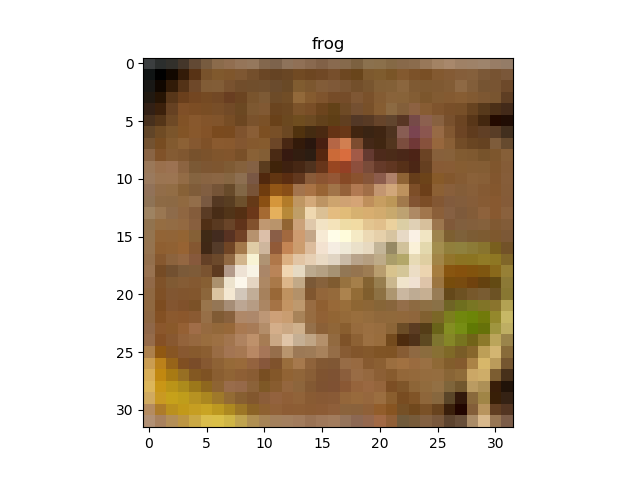

Text(0.5, 1.0, 'frog')

In [4]:
plt.imshow(X_train0[0], interpolation='nearest')
plt.title(inv_class_dict[y_train[0]])

<IPython.core.display.Javascript object>


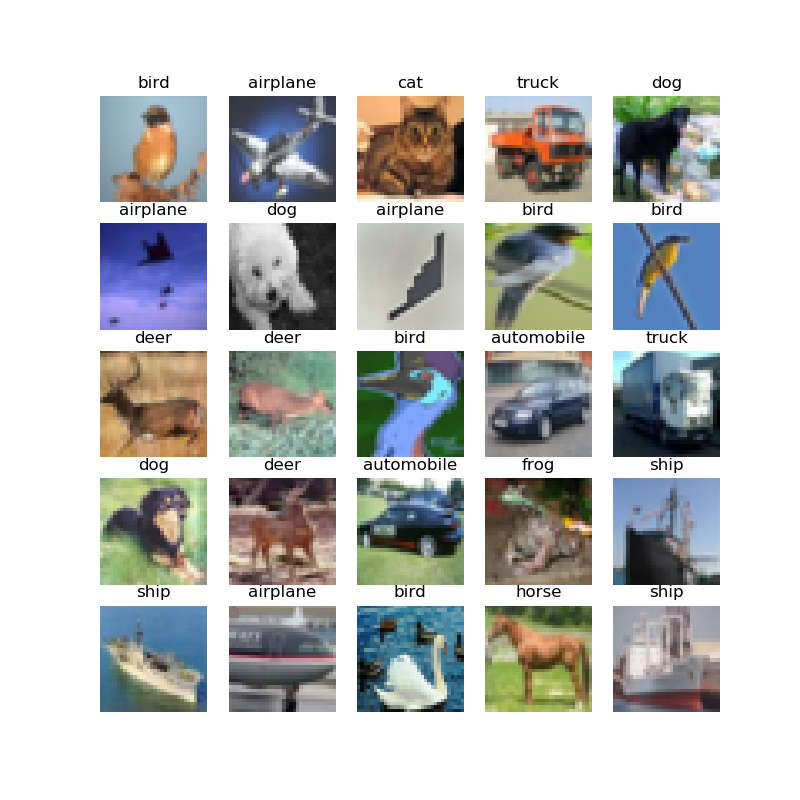

In [5]:
#Visualizing CIFAR 10
fig, axes1 = plt.subplots(5,5,figsize=(8,8))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(50000))
        axes1[j][k].set_axis_off()
        axes1[j][k].set_title(inv_class_dict[y_train[i]])
        axes1[j][k].imshow(X_train0[i], interpolation='nearest')

In [6]:
X_train = X_train0/255 
X_test = X_test0/255 

In [7]:
#Labels to binary
y_train_binary = tf.keras.utils.to_categorical(y_train,num_classes)
y_test_binary = tf.keras.utils.to_categorical(y_test,num_classes)

## Training a DNN

In [ ]:
def create_CNN_model(inp_shape, num_classes, p=0.2):
    model = Sequential(name='CNN')
    model.add(Conv2D(32, kernel_size=(3, 3),
               activation='relu',
               input_shape=inp_shape,
               padding='same', name='Conv_1'))
    model.add(BatchNormalization(name='Bn_1')) 
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',padding='same',  name='Conv_2'))
    model.add(BatchNormalization(name='Bn_2')) 
    model.add(MaxPooling2D(pool_size=(2, 2), name='Max_pool_1'))  
    model.add(Dropout(p, name='Drop_1'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same',  name='Conv_3'))
    model.add(BatchNormalization(name='Bn_3')) 
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same',  name='Conv_4'))
    model.add(BatchNormalization(name='Bn_4')) 
    model.add(MaxPooling2D(pool_size=(2, 2), name='Max_pool_2'))  
    model.add(Dropout(p, name='Drop_2'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same',  name='Conv_5'))
    model.add(BatchNormalization(name='Bn_5')) 
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same',  name='Conv_6'))
    model.add(BatchNormalization(name='Bn_6')) 
    model.add(MaxPooling2D(pool_size=(2, 2), name='Max_pool_3'))  
    model.add(Dropout(p, name='Drop_3'))
    model.add(Flatten(name = 'Flatten_1'))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization(name='Bn_7')) 
    model.add(Dropout(p, name='Drop_4'))
    model.add(Dense(num_classes, name='logits'))
    model.add(Activation('softmax', name = 'probs'))
    print(model.summary())
    
    return model

def train_CNN_model(model, X_train, y_train, X_val, y_val, model_dir, t, batch_size=256, epochs=50, name = NAME):
    
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])

    # checkpoint
    chk_path = os.path.join(model_dir, 'best_{}_{}'.format(name,t))
    checkpoint = ModelCheckpoint(chk_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    tensorboard = TensorBoard(log_dir="logs/{}_{}".format(name,t))
    callbacks_list = [checkpoint, tensorboard]

    history = model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                shuffle=True,
                validation_data=(X_val, y_val),
                callbacks=callbacks_list)
    
    #Saving the model
    model.save(os.path.join(model_dir, 'final_{}_{}'.format(NAME,t)))
    
    return model, history


def calculate_metrics(model, X_test, y_test_binary):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(y_test_binary, axis=1)
    mismatch = np.where(y_true != y_pred)
    cf_matrix = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    #micro_f1 = f1_score(y_true, y_pred, average='micro')
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    
    return cf_matrix, accuracy, macro_f1, mismatch, y_pred

In [10]:
#CNN Model
model = create_CNN_model(X_train.shape[1:], num_classes, 0.3)

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
Bn_1 (BatchNormalization)    (None, 32, 32, 32)        128       
_________________________________________________________________
Conv_2 (Conv2D)              (None, 32, 32, 32)        9248      
_________________________________________________________________
Bn_2 (BatchNormalization)    (None, 32, 32, 32)        128       
_________________________________________________________________
Max_pool_1 (MaxPooling2D)    (None, 16, 16, 32)        0         
_________________________________________________________________
Drop_1 (Dropout)             (None, 16, 16, 32)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 16, 16, 64)        18496   

In [11]:
#Training Model
t = int(time.time())
model, H = train_CNN_model(model, X_train, y_train_binary, X_test, y_test_binary, model_dir, t, batch_size=256, epochs=100)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
49920/50000 [============================>.] - ETA: 0s - loss: 1.6511 - acc: 0.4187- 
Epoch 00001: val_acc improved from -inf to 0.11210, saving model to Models/best_Cifar10_CNN_1571866172
50000/50000 [==============================] - 9s 174us/sample - loss: 1.6509 - acc: 0.4188 - val_loss: 2.8110 - val_acc: 0.1121
Epoch 2/100
49920/50000 [============================>.] - ETA: 0s - loss: 1.1783 - acc: 0.5818- ETA: 4s - loss: 1.2625 - acc: 0.549 - ETA: 4s - lo
Epoch 00002: val_acc improved from 0.11210 to 0.18240, saving model to Models/best_Cifar10_CNN_1571866172
50000/50000 [==============================] - 7s 146us/sample - loss: 1.1780 - acc: 0.5819 - val_loss: 2.7243 - val_acc: 0.1824
Epoch 3/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.9607 - acc: 0.6627
Epoch 00003: val_acc improved from 0.18240 to 0.61570, saving model to Models/best_Cifar10_CNN_1571866172
50000/50000 [======================

Epoch 28/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.2897 - acc: 0.9002
Epoch 00028: val_acc did not improve from 0.84770
50000/50000 [==============================] - 7s 137us/sample - loss: 0.2896 - acc: 0.9002 - val_loss: 0.5576 - val_acc: 0.8330
Epoch 29/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.2773 - acc: 0.9035
Epoch 00029: val_acc did not improve from 0.84770
50000/50000 [==============================] - 7s 139us/sample - loss: 0.2774 - acc: 0.9034 - val_loss: 0.5405 - val_acc: 0.8441
Epoch 30/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.2732 - acc: 0.9063
Epoch 00030: val_acc did not improve from 0.84770
50000/50000 [==============================] - 7s 140us/sample - loss: 0.2731 - acc: 0.9062 - val_loss: 0.5300 - val_acc: 0.8454
Epoch 31/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.2682 - acc: 0.9075
Epoch 00031: val_acc did not improve from 0.84770
50000/50000 [============

Epoch 56/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.1690 - acc: 0.9409
Epoch 00056: val_acc improved from 0.86060 to 0.86360, saving model to Models/best_Cifar10_CNN_1571866172
50000/50000 [==============================] - 7s 147us/sample - loss: 0.1690 - acc: 0.9409 - val_loss: 0.4972 - val_acc: 0.8636
Epoch 57/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.1730 - acc: 0.9395
Epoch 00057: val_acc did not improve from 0.86360
50000/50000 [==============================] - 7s 142us/sample - loss: 0.1728 - acc: 0.9396 - val_loss: 0.5799 - val_acc: 0.8470
Epoch 58/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.1714 - acc: 0.9399- ETA: 6s - loss: 0.14 - ETA - ETA: 0s - loss: 0.1710 - acc: 0
Epoch 00058: val_acc did not improve from 0.86360
50000/50000 [==============================] - 7s 141us/sample - loss: 0.1713 - acc: 0.9400 - val_loss: 0.5560 - val_acc: 0.8467
Epoch 59/100
49920/50000 [============================

Epoch 85/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.1275 - acc: 0.9556
Epoch 00085: val_acc did not improve from 0.86720
50000/50000 [==============================] - 7s 140us/sample - loss: 0.1275 - acc: 0.9556 - val_loss: 0.5242 - val_acc: 0.8667
Epoch 86/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.1296 - acc: 0.9553
Epoch 00086: val_acc did not improve from 0.86720
50000/50000 [==============================] - 7s 142us/sample - loss: 0.1297 - acc: 0.9553 - val_loss: 0.5635 - val_acc: 0.8603
Epoch 87/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.1298 - acc: 0.9557
Epoch 00087: val_acc did not improve from 0.86720
50000/50000 [==============================] - 7s 142us/sample - loss: 0.1299 - acc: 0.9557 - val_loss: 0.5549 - val_acc: 0.8589
Epoch 88/100
49920/50000 [============================>.] - ETA: 0s - loss: 0.1283 - acc: 0.9551
Epoch 00088: val_acc did not improve from 0.86720
50000/50000 [============

<IPython.core.display.Javascript object>


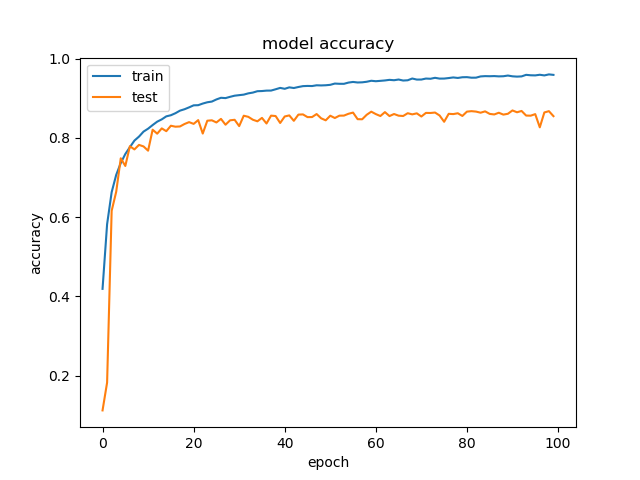

<IPython.core.display.Javascript object>


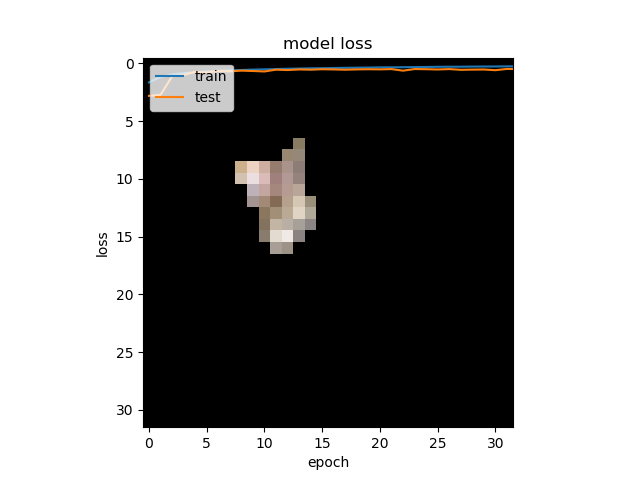

In [12]:
# summarize history for accuracy and loss
plt.figure()
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure()
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Evaluation

In [8]:
#Load Trained Model
model = load_model(model_dir + '/best_Cifar10_CNN_1571866172')
print(model.summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
Bn_1 (BatchNormalization)    (None, 32, 32, 32)        128       
_________________________________________________________________
Conv_2 (Conv2D)              (None, 32, 32, 32)        9248      
_____________________________________________________

In [ ]:
cf_matrix, accuracy, macro_f1, mismatch, y_pred = calculate_metrics(model, X_test, y_test_binary)
print('Accuracy : {}'.format(accuracy))
print('F1-score : {}'.format(macro_f1))
print(cf_matrix)